In [303]:
import pandas as pd
import numpy as np
import math as maths
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from matplotlib import ticker, cm
from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
from pathlib import Path  
style.use('default') or plt.style.use('default')
import seaborn as sns


In [304]:
# Read in data

Lines_n3 = ['n3Strain950_1940', 'n3Strain960_1930', 'n3Strain960_1940', 'n3Strain960_1950', 'n3Strain970_1930', 'n3Strain970_1940', 'n3Strain970_1950']
Lines_n3_names = ['(950,1940)', '(960,1930)', '(960,1940)', '(960,1950)', '(970,1930)', '(970,1940)', '(970,1950)']
Lines_n4 = ['n4Strain950_1940', 'n4Strain960_1930', 'n4Strain960_1940', 'n4Strain960_1950', 'n4Strain970_1930', 'n4Strain970_1940', 'n4Strain970_1950']  
Lines_n4_names = ['(950,1940)', '(960,1930)', '(960,1940)', '(960,1950)', '(970,1930)', '(970,1940)', '(970,1950)']  
Lines_Age_n3 = ['n3Age950_1940', 'n3Age960_1930', 'n3Age960_1940', 'n3Age960_1950', 'n3Age970_1930', 'n3Age970_1940', 'n3Age970_1950']
Lines_Age_n4 = ['n4Age950_1940', 'n4Age960_1930', 'n4Age960_1940', 'n4Age960_1950', 'n4Age970_1930', 'n4Age970_1940', 'n4Age970_1950']

Data_n3 = {}
Data_n4 = {}
Data_Age_n3 = {}
Data_Age_n4 = {}

def VelMagH(vx, vy):
    return np.sqrt(vx**2 + vy**2)
def VelDirxH(vx, vy):
    return vx / np.sqrt(vx**2 + vy**2)
def VelDiryH(vx, vy):
    return vy / np.sqrt(vx**2 + vy**2)
def StrainRateDir(exx, eyy, exy, vecx, vecy):
    arr = np.array([[exx, exy], [exy, eyy]])
    vec = np.array([vecx, vecy])
    strainrate_new = arr * vec
    print(vec)
    if strainrate_new[0][0] + strainrate_new[1][1] < 0:
        strainrate_new = -strainrate_new
    exx_new = strainrate_new[0][0]
    eyy_new = strainrate_new[1][1]
    exy_new = strainrate_new[0][1]
    return exx_new, exy_new, eyy_new

# Define a function for finding the angle between the velocity vector and the x-axis

def Angle(row):
    return maths.atan2(row['velocity:1'], row['velocity:1'])

def ShearStrainRate(row):
    #return row['strainrate 4'] * np.cos(row['vel angle'] - np.pi/2.0) + row['strainrate 2'] * np.sin(row['vel angle'] - np.pi/2.0)
    return row['strainrate 4'] * np.cos(row['vel angle']) + row['strainrate 2'] * np.sin(row['vel angle'])

def ExxStrainRate(row):
    #return row['strainrate 1'] * np.cos(row['vel angle'] - np.pi/2.0) + row['strainrate 4'] * np.sin(row['vel angle'] - np.pi/2.0)
    return row['strainrate 1'] * np.cos(row['vel angle']) + row['strainrate 4'] * np.sin(row['vel angle'])

def EyyStrainRate(row):
    #return -row['strainrate 4'] * np.sin(row['vel angle'] - np.pi/2.0) + row['strainrate 2'] * np.cos(row['vel angle'] - np.pi/2.0)
    return -row['strainrate 4'] * np.sin(row['vel angle']) + row['strainrate 2'] * np.cos(row['vel angle'])

for i in Lines_n3:
    Data_n3[i] = pd.read_csv('../Simulations/DerwaelSimulations/DepthData/' + str(i) + '.csv', sep=",")
    Data_n3[i] = Data_n3[i].sort_values('height')
    Data_n3[i]['vel mag'] = Data_n3[i][['velocity:0', 'velocity:1']].apply(lambda x: VelMagH(x['velocity:0'], x['velocity:1']), axis=1)
    Data_n3[i]['vel dir x'] = Data_n3[i][['velocity:0', 'velocity:1']].apply(lambda x: VelDirxH(x['velocity:0'], x['velocity:1']), axis=1)
    Data_n3[i]['vel dir y'] = Data_n3[i][['velocity:0', 'velocity:1']].apply(lambda x: VelDiryH(x['velocity:0'], x['velocity:1']), axis=1)
    Data_n3[i]['vel angle'] = Data_n3[i].apply(lambda row: Angle(row), axis=1)
    Data_n3[i]['str exx'] = Data_n3[i].apply(lambda row: ExxStrainRate(row), axis=1)
    Data_n3[i]['str eyy'] = Data_n3[i].apply(lambda row: EyyStrainRate(row), axis=1)
    Data_n3[i]['str exy'] = Data_n3[i].apply(lambda row: ShearStrainRate(row), axis=1)
    Data_n3[i]['height norm'] = Data_n3[i]['height']/Data_n3[i]['height'].max()
    if Data_n3[i]['str exx'][0] + Data_n3[i]['str eyy'][0] < 0:
        Data_n3[i]['str exx'] = -Data_n3[i]['str exx']
        Data_n3[i]['str eyy'] = -Data_n3[i]['str eyy']
        Data_n3[i]['str exy'] = -Data_n3[i]['str exy']
    #Data_n3[i]['str exx'] = Data_n3[i][['strainrate 1', 'strainrate 2', 'strainrate 4', 'vel dir x', 'vel dir y']].apply(lambda x: StrainRateDir(x['strainrate 1'], x['strainrate 2'], x['strainrate 4'], x['vel dir x'], x['vel dir y'])[0], axis=1)
    #Data_n3[i]['str eyy'] = Data_n3[i][['strainrate 1', 'strainrate 2', 'strainrate 4', 'vel dir x', 'vel dir y']].apply(lambda x: StrainRateDir(x['strainrate 1'], x['strainrate 2'], x['strainrate 4'], x['vel dir x'], x['vel dir y'])[1], axis=1)
    #Data_n3[i]['str exy'] = Data_n3[i][['strainrate 1', 'strainrate 2', 'strainrate 4', 'vel dir x', 'vel dir y']].apply(lambda x: StrainRateDir(x['strainrate 1'], x['strainrate 2'], x['strainrate 4'], x['vel dir x'], x['vel dir y'])[2], axis=1)
for i in Lines_n4:
    Data_n4[i] = pd.read_csv('../Simulations/DerwaelSimulations/DepthData/' + str(i) + '.csv', sep=",")
    Data_n4[i] = Data_n4[i].sort_values('height')
    Data_n4[i]['vel mag'] = Data_n4[i][['velocity:0', 'velocity:1']].apply(lambda x: VelMagH(x['velocity:0'], x['velocity:1']), axis=1)
    Data_n4[i]['vel dir x'] = Data_n4[i][['velocity:0', 'velocity:1']].apply(lambda x: VelDirxH(x['velocity:0'], x['velocity:1']), axis=1)
    Data_n4[i]['vel dir y'] = Data_n4[i][['velocity:0', 'velocity:1']].apply(lambda x: VelDiryH(x['velocity:0'], x['velocity:1']), axis=1)
    Data_n4[i]['vel angle'] = Data_n4[i].apply(lambda row: Angle(row), axis=1)
    Data_n4[i]['str exx'] = Data_n4[i].apply(lambda row: ExxStrainRate(row), axis=1)
    Data_n4[i]['str eyy'] = Data_n4[i].apply(lambda row: EyyStrainRate(row), axis=1)
    Data_n4[i]['str exy'] = Data_n4[i].apply(lambda row: ShearStrainRate(row), axis=1)
    Data_n4[i]['height norm'] = Data_n4[i]['height']/Data_n4[i]['height'].max()
    if Data_n4[i]['str exx'][0] + Data_n4[i]['str eyy'][0] < 0:
        Data_n4[i]['str exx'] = -Data_n4[i]['str exx']
        Data_n4[i]['str eyy'] = -Data_n4[i]['str eyy']
        Data_n4[i]['str exy'] = -Data_n4[i]['str exy']
    #Data_n4[i]['str exx'] = Data_n4[i][['strainrate 1', 'strainrate 2', 'strainrate 4', 'vel dir x', 'vel dir y']].apply(lambda x: StrainRateDir(x['strainrate 1'], x['strainrate 2'], x['strainrate 4'], x['vel dir x'], x['vel dir y'])[0], axis=1)
    #Data_n4[i]['str eyy'] = Data_n4[i][['strainrate 1', 'strainrate 2', 'strainrate 4', 'vel dir x', 'vel dir y']].apply(lambda x: StrainRateDir(x['strainrate 1'], x['strainrate 2'], x['strainrate 4'], x['vel dir x'], x['vel dir y'])[1], axis=1)
    #Data_n4[i]['str exy'] = Data_n4[i][['strainrate 1', 'strainrate 2', 'strainrate 4', 'vel dir x', 'vel dir y']].apply(lambda x: StrainRateDir(x['strainrate 1'], x['strainrate 2'], x['strainrate 4'], x['vel dir x'], x['vel dir y'])[2], axis=1)
for i in Lines_Age_n3:
    Data_Age_n3[i] = pd.read_csv('../Simulations/DerwaelSimulations/DepthData/' + str(i) + '.csv', sep=",")
    Data_Age_n3[i] = Data_Age_n3[i].sort_values('height')
for i in Lines_Age_n4:
    Data_Age_n4[i] = pd.read_csv('../Simulations/DerwaelSimulations/DepthData/' + str(i) + '.csv', sep=",")
    Data_Age_n4[i] = Data_Age_n4[i].sort_values('height')


In [305]:
maths.atan2(0, -1), np.pi

(3.141592653589793, 3.141592653589793)

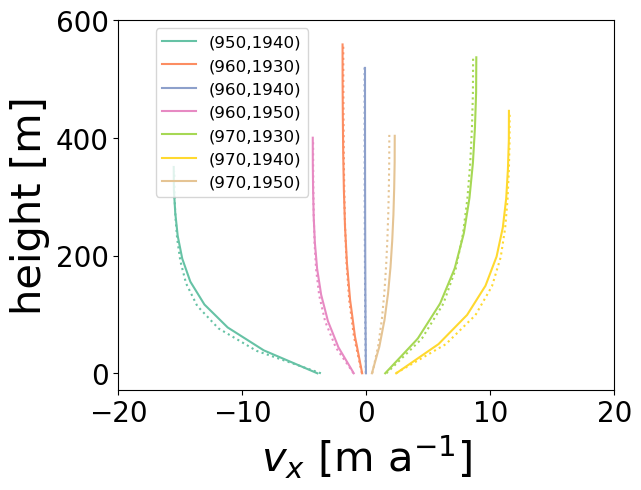

In [306]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots()
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['velocity:0'], Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i])
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['velocity:0'], Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i])
ax.legend(fontsize=12, bbox_to_anchor=(0.4,0.5))
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([0, 200, 400, 600])
ax.set_xlabel('$v_x$ [m a$^{-1}$]', fontsize = 30)
ax.set_ylabel('height [m]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=20)

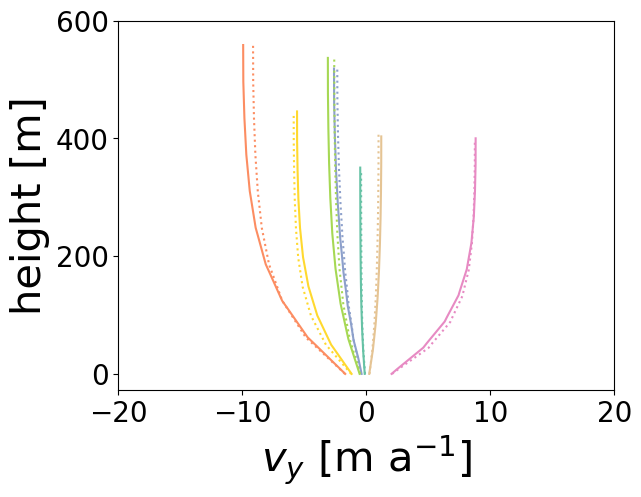

In [307]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots()
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['velocity:1'], Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i])
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['velocity:1'], Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i])
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([0, 200, 400, 600])
ax.set_xlabel('$v_y$ [m a$^{-1}$]', fontsize = 30)
ax.set_ylabel('height [m]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=20)

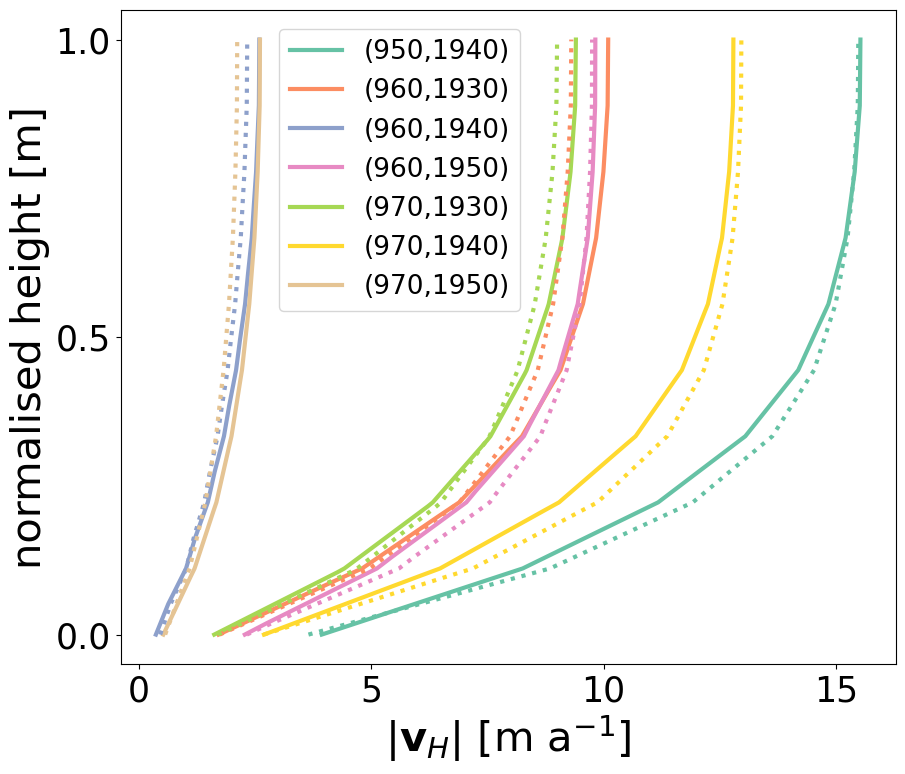

In [318]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots(figsize=(10, 8.5))
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['vel mag'], Data_n3[Lines_n3[i]]['height norm'], label=Lines_n3_names[i], color=colors[i], linewidth=3.0)
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['vel mag'], Data_n4[Lines_n4[i]]['height norm'], linestyle=':', color=colors[i], linewidth=3.0)
ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('$|\mathbf{v}_H|$ [m a$^{-1}$]', fontsize = 30)
ax.set_ylabel('normalised height [m]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=19, bbox_to_anchor=(0.36,0.52))
fig.savefig('../Figures/DerwaelProfileVelMag.jpg', format='jpg', dpi=700, bbox_inches = "tight")


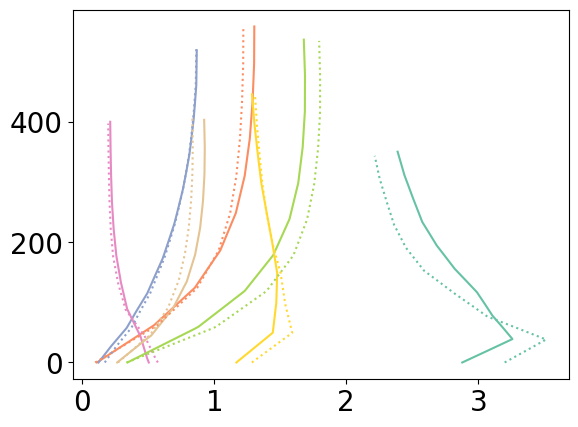

In [309]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots()
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['strainrate 1']*1000, Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i])
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['strainrate 1']*1000, Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i])

ax.tick_params(axis='both', which='major', labelsize=20)
fig.savefig('../Figures/OriginalStrainRate_xx_adj.jpg', format='jpg', dpi=700, bbox_inches = "tight")


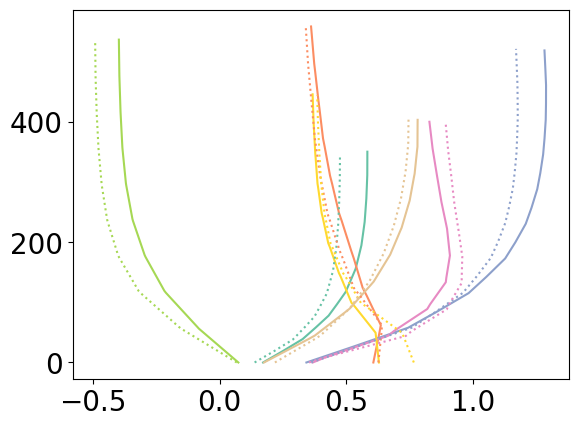

In [310]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots()
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['strainrate 2']*1000, Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i])
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['strainrate 2']*1000, Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i])

ax.tick_params(axis='both', which='major', labelsize=20)
fig.savefig('../Figures/OriginalStrainRate_yy_adj.jpg', format='jpg', dpi=700, bbox_inches = "tight")


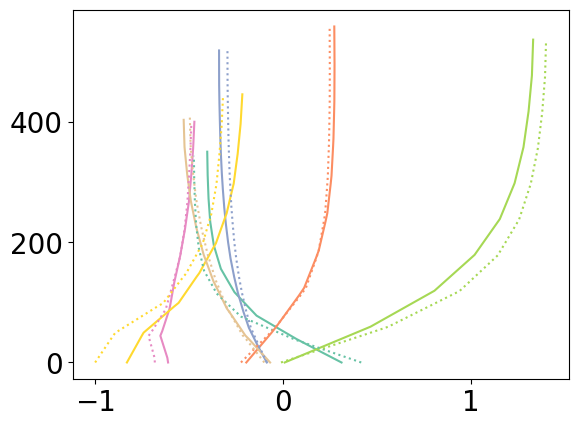

In [311]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots()
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['strainrate 4']*1000, Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i])
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['strainrate 4']*1000, Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i])

ax.tick_params(axis='both', which='major', labelsize=20)
fig.savefig('../Figures/OriginalStrainRate_xy_adj.jpg', format='jpg', dpi=700, bbox_inches = "tight")


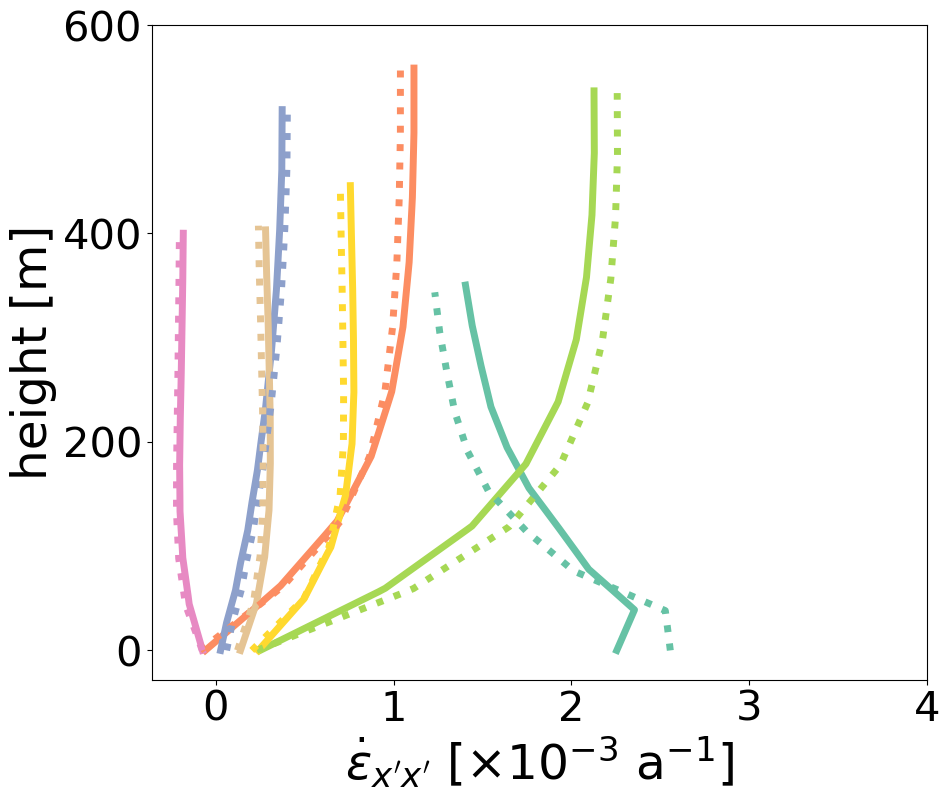

In [312]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots(figsize=(10, 8.5))
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['str exx']*1000, Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i], linewidth=5.0)
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['str exx']*1000, Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i], linewidth=5.0)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 200, 400, 600])
ax.set_xlabel(r"$\dot{\epsilon}_{x'x'}$ [$\times 10^{-3}$ a$^{-1}$]", fontsize = 35)
ax.set_ylabel('height [m]', fontsize = 35)
ax.tick_params(axis='both', which='major', labelsize=30)
fig.savefig('../Figures/DerwaelProfileStrainRate_xx_adj.jpg', format='jpg', dpi=700, bbox_inches = "tight")


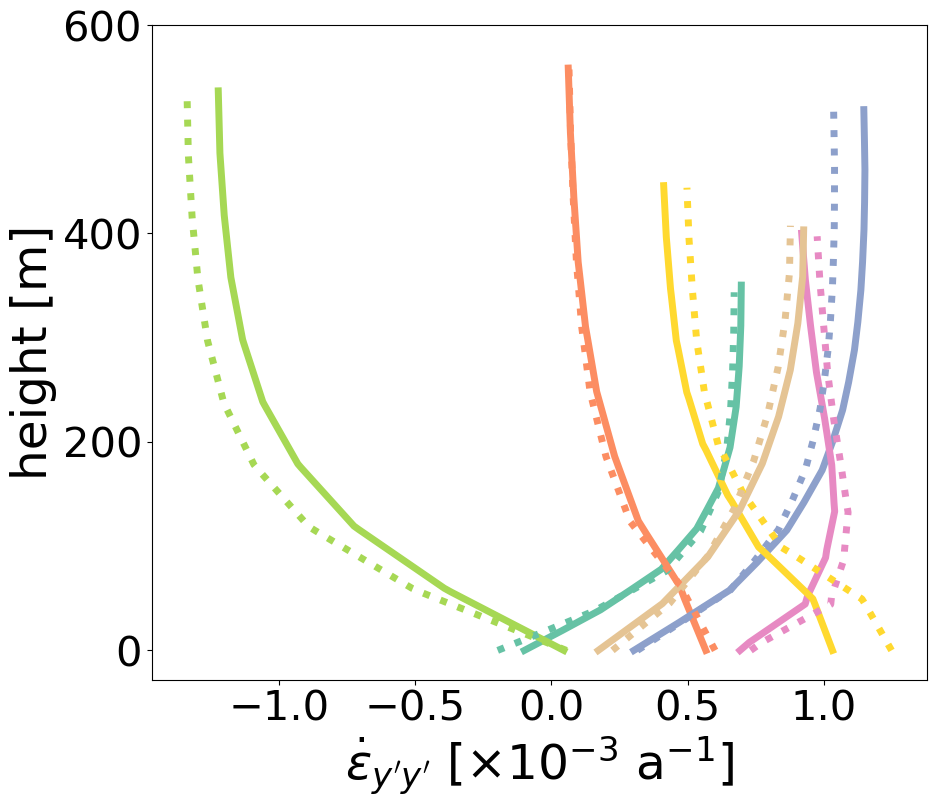

In [313]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots(figsize=(10, 8.5))
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['str eyy']*1000, Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i], linewidth=5.0)
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['str eyy']*1000, Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i], linewidth=5.0)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([0, 200, 400, 600])
ax.set_xlabel(r"$\dot{\epsilon}_{y'y'}$ [$\times 10^{-3}$ a$^{-1}$]", fontsize = 35)
ax.set_ylabel('height [m]', fontsize = 35)
ax.tick_params(axis='both', which='major', labelsize=30)
fig.savefig('../Figures/DerwaelProfileStrainRate_yy_adj.jpg', format='jpg', dpi=700, bbox_inches = "tight")


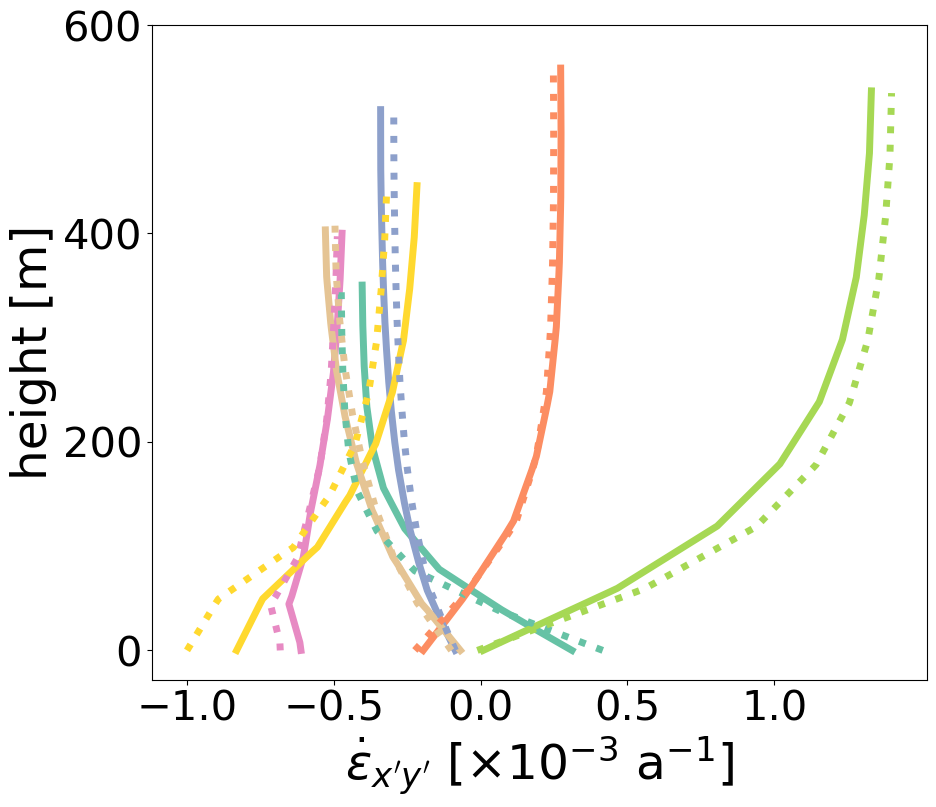

In [314]:
# Plot lines

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots(figsize=(10, 8.5))
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['strainrate 4']*1000, Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i], linewidth=5.0)
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['strainrate 4']*1000, Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i], linewidth=5.0)
ax.set_xticks([-1.0, -0.5, 0, 0.5, 1.0])
ax.set_yticks([0, 200, 400, 600])
ax.set_xlabel(r"$\dot{\epsilon}_{x'y'}$ [$\times 10^{-3}$ a$^{-1}$]", fontsize = 35)
ax.set_ylabel('height [m]', fontsize = 35)
ax.tick_params(axis='both', which='major', labelsize=30)
fig.savefig('../Figures/DerwaelProfileStrainRate_xy_adj.jpg', format='jpg', dpi=700, bbox_inches = "tight")
#'str exy'

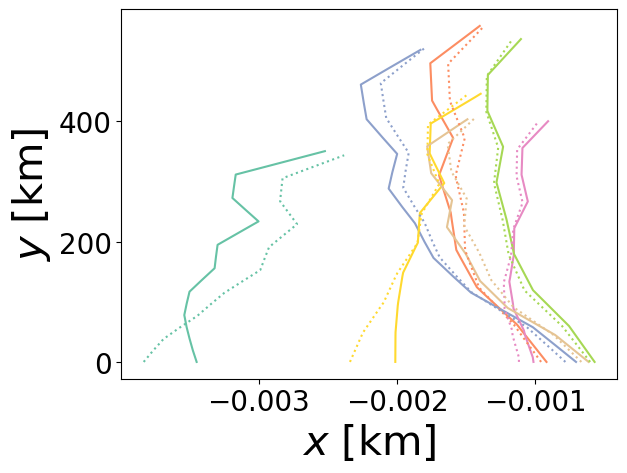

In [315]:
# Plot line

colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots()
for i in range(len(Lines_n3)):
    ax.plot(Data_n3[Lines_n3[i]]['strainrate 3'], Data_n3[Lines_n3[i]]['height'], label=Lines_n3_names[i], color=colors[i])
for i in range(len(Lines_n4)):
    ax.plot(Data_n4[Lines_n4[i]]['strainrate 3'], Data_n4[Lines_n4[i]]['height'], linestyle=':', color=colors[i])
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('$y$ [km]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=20)

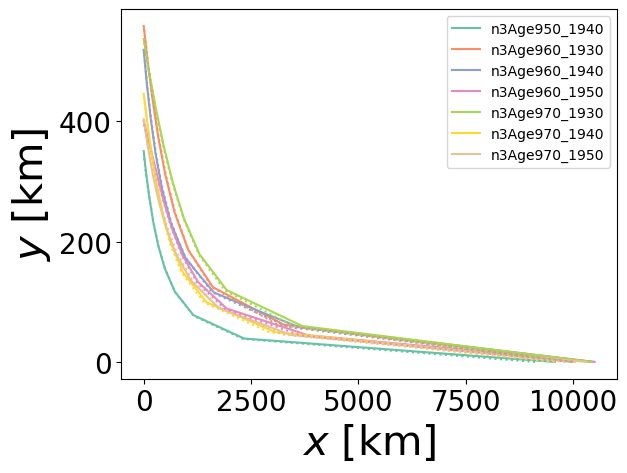

In [316]:
colors = sns.color_palette("Set2").as_hex()

fig, ax = plt.subplots()
for i in range(len(Lines_Age_n3)):
    ax.plot(Data_Age_n3[Lines_Age_n3[i]]['age'], Data_Age_n3[Lines_Age_n3[i]]['height'], label=Lines_Age_n3[i], color=colors[i])
for i in range(len(Lines_Age_n4)):
    ax.plot(Data_Age_n4[Lines_Age_n4[i]]['age'], Data_Age_n4[Lines_Age_n4[i]]['height'], linestyle=':', color=colors[i])
#ax.set_xscale('log')
#ax.set_ylim([-10,50])
ax.legend()
ax.set_xlabel('$x$ [km]', fontsize = 30)
ax.set_ylabel('$y$ [km]', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=20)